# Spampinato mice retina mea252ch pair recording - 2

## Part 2) Ground-truth comparison

This set of notebooks the dataset is from paired juxtacellular/extracellular recordings from mice retina _in vitro_.
The MEA has 252 channels.

The official publication of this open dataset can be found at the following address:
https://zenodo.org/record/1205233#.W9mq1HWLTIF

These datasets were used by Pierre Yger et al in the following "spyking circus" paper:
https://elifesciences.org/articles/34518


After inspecting the juxta-cellular data, we found that some recordings don't have a good enough quality to be considered as "ground truth". To be "ground truth", a unit is required to be stable in the detection, peak signal-to-noise ratio (SNR) and amplitude.

At the end of our quality assessment ([**"spampinato-mice-retina-mea252ch-pair-recording-part1"**](https://spikeinterface.github.io/blog/spampinato-mice-retina-mea252ch-pair-recording-part1/)), some files are removed for this main study.


Author: [Samuel Garcia](https://github.com/samuelgarcia), CRNL, Lyon

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

### Installation and imports

  1. to create a folder **basedir**.
  2. download all files from the zenodo link
  3. move them in a subfolder **basedir/original_files** (20160415_patch2.tar.gz, ...)
  4. and then execute cells by cell this notebook

In [16]:
# import everything
import os, getpass
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

from spikeinterface.comparison import GroundTruthStudy

In [ ]:
# clone and install MATLAB sorters

# kilosort2
!git clone https://github.com/MouseLand/Kilosort2.git
kilosort2_path = './Kilosort2'
ss.Kilosort2Sorter.set_kilosort2_path(kilosort2_path)

# kilosort
!git clone https://github.com/cortex-lab/KiloSort.git
kilosort_path = './KiloSort'
ss.KilosortSorter.set_kilosort_path(kilosort_path)

# ironclust
!git clone https://github.com/flatironinstitute/ironclust.git
ironclust_path = './ironclust'
ss.IronclustSorter.set_ironclust_path(ironclust_path)

In [17]:
si.print_spikeinterface_version()
ss.print_sorter_versions()

spikeinterface: 0.9.9
  * spikeextractor: 0.8.4
  * spiketoolkit: 0.6.3
  * spikesorters: 0.3.3
  * spikecomparison: 0.2.6
  * spikewidgets: 0.4.3

herdingspikes: 0.3.7+git.45665a2b6438
ironclust: 5.9.8
kilosort: git-cd040da1963d
kilosort2: git-e243c934339e
spykingcircus: 0.9.7
tridesclous: 1.6.1.dev


In [18]:
# my working path
basedir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/Pierre/zenodo/'

# input file
recording_folder = basedir + 'original_files/'

# ground truth information
ground_truth_folder = basedir + 'ground_truth/'

# where output will be
study_folder = basedir + 'study_gt252/'

# sorter list
sorter_list = ['tridesclous']

# selected recordings (8/19)
rec_names = [
    '20160415_patch2',
    '20170803_patch1',
    '20160426_patch3', 
    '20170725_patch1',
    '20170621_patch1',
    '20160426_patch2', 
    '20170728_patch2',
    '20170713_patch1',
]


In [19]:
%matplotlib inline

# some matplotlib hack to prettify figure
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    

## Step 1 : Clean original dataset

## Setup study

In this step:
  * we create a dict of (recordings+sorting)
  * and call the function ```setup_comparison_study(study_folder, gt_dict)```

Internally, spikeinterface copies all recordings and ground-truth sorting into an organised folder.


Important note:
  * the file have 256 channels but only 252 are useful.
    The PRB file contains all channels needed so we need to explicitly use **grouping_property='group'**
    to be sure to only take in account the channels in the unique group.
  * This step has to run only once and takes some times because of copy.

In [ ]:
gt_dict = {}
for rec_name in rec_names:

    # find raw file
    dirname = recording_folder + rec_name + '/'
    for f in os.listdir(dirname):
        if f.endswith('.raw') and not f.endswith('juxta.raw'):
            mea_filename = dirname + f

    # raw files have an internal offset that depend on the channel count
    # a simple built header can be parsed to get it
    with open(mea_filename.replace('.raw', '.txt'), mode='r') as f:
        offset = int(re.findall(r'padding = (\d+)', f.read())[0])

    # recording
    rec = se.BinDatRecordingExtractor(mea_filename, 20000., 256, 'uint16', offset=offset, time_axis=0)

    # this reduce channel count to 252
    rec = se.load_probe_file(rec, basedir + 'mea_256.prb')

    # gt sorting
    gt_indexes = np.fromfile(ground_truth_folder + rec_name + '/juxta_peak_indexes.raw', dtype='int64')
    sorting_gt = se.NumpySortingExtractor()
    sorting_gt.set_times_labels(gt_indexes, np.zeros(gt_indexes.size, dtype='int64'))
    sorting_gt.set_sampling_frequency(20000.0)

    gt_dict[rec_name] = (rec, sorting_gt)


study = GroundTruthStudy.create(study_folder, gt_dict)

## Get signal to noise ratio for all units

In [20]:
study = GroundTruthStudy(study_folder)
snr = study.concat_all_snr()
snr

snr
rec_name        gt_unit_id           
20160415_patch2 0            7.647741
20170803_patch1 0           13.230232
20160426_patch3 0            7.270211
20170725_patch1 0           28.532387
20170621_patch1 0           15.133425
20160426_patch2 0            4.661795
20170728_patch2 0           23.652615
20170713_patch1 0           14.934497

Text(0.5, 0, 'GT units SNR')

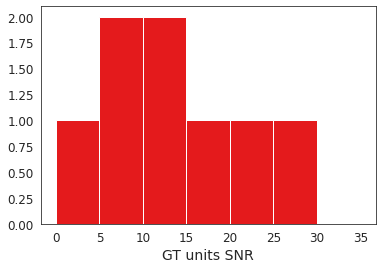

In [21]:
fig, ax = plt.subplots()
ax.hist(snr['snr'].values, bins=np.arange(0, 40, 5))
ax.set_xlabel('GT units SNR')

## Run all sorters

In [22]:
sorter_list = ['herdingspikes', 'ironclust', 'kilosort2',  
               'spykingcircus', 'tridesclous']

In [ ]:
study = GroundTruthStudy(study_folder)

study.run_sorters(sorter_list, mode='keep', verbose=False)

## Run comparison with ground truth and retreive result tables

In [23]:
# this copy sorting is necessary to copy results from sorter
# into a centralize folder with all results
study.copy_sortings()


In [24]:
# this run all comparison to GT
# exhaustive_gt=False because it is a pair recording so only one GT units
study.run_comparisons(exhaustive_gt=False, match_score=0.1, overmerged_score=0.2)

In [25]:
# this retrieve results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

In [26]:
## Run times

In [27]:
dataframes['run_times'].set_index(['rec_name', 'sorter_name']).unstack('sorter_name')

run_time                                        \
sorter_name     herdingspikes   ironclust   kilosort2 spykingcircus   
rec_name                                                              
20160415_patch2    142.888554  108.045776  229.796090    745.985181   
20160426_patch2     85.068679   78.040375   50.278513    315.495001   
20160426_patch3     72.955193   65.033961   46.270309    265.166210   
20170621_patch1    162.408083  118.569352  190.309174    603.793946   
20170713_patch1    169.336252  133.652825  246.374550    799.341534   
20170725_patch1    152.863248  101.050823  201.603548    710.756077   
20170728_patch2    150.883882   99.282168  150.312809    487.173840   
20170803_patch1    148.814701  114.053511  216.422934    753.743665   

                             
sorter_name     tridesclous  
rec_name                     
20160415_patch2  391.462280  
20160426_patch2  109.498236  
20160426_patch3   96.272756  
20170621_patch1  343.447162  
20170713_patch1  464.072922  
20170725_patch1  390.276237  
20170728_patch2  309.182291  
20170803_patch1  433.630640

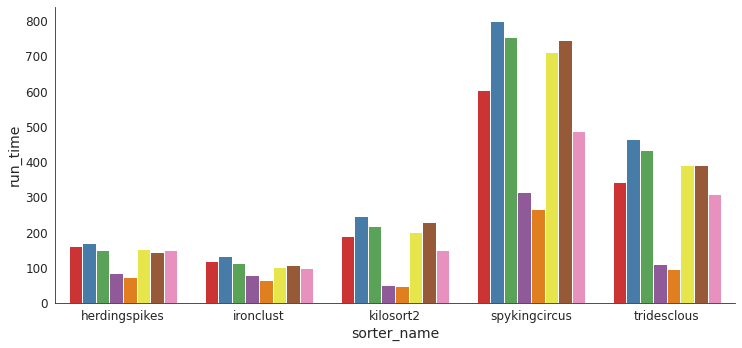

In [28]:
sns.set_palette(sns.color_palette("Set1"))

#fig, ax = plt.subplots()
g = sns.catplot(data=dataframes['run_times'], x='sorter_name', y='run_time',
                hue="rec_name",
                order=sorter_list,
                kind='bar',
               legend=False)
g.fig.set_size_inches(12,5)

#ax.set_yscale('log')
#ax.set_ylabel('Run time (s)');
#ax.set_xlabel(None);
fig.axes[0].set_xticklabels(sorter_list, rotation=40, ha='right');

## accuracy/precision/recall scores per sorters

rec_name    sorter_name    metric     score
0    20160426_patch3  herdingspikes  accuracy  0.694297
1    20170725_patch1  herdingspikes  accuracy  0.919708
2    20170713_patch1  spykingcircus  accuracy  0.933659
3    20160426_patch3      kilosort2  accuracy  0.703873
4    20160426_patch2    tridesclous  accuracy  0.426621
..               ...            ...       ...       ...
115  20170803_patch1  spykingcircus    recall  0.970153
116  20160415_patch2  spykingcircus    recall  0.937962
117  20170728_patch2  herdingspikes    recall  0.994103
118  20170728_patch2      kilosort2    recall  0.998736
119  20170713_patch1  herdingspikes    recall  0.973463

[120 rows x 4 columns]

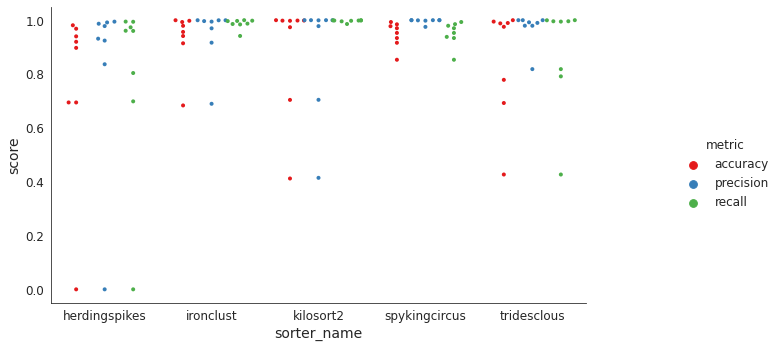

In [29]:
#fig, ax = plt.subplots(figsize=(12,4))
#fig.tight_layout()

sns.set_palette(sns.color_palette("Set1"))

df = pd.melt(dataframes['perf_by_units'], id_vars=['rec_name', 'sorter_name'],
            var_name='metric', value_name='score', 
            value_vars=('accuracy','precision', 'recall'))
display(df)

# df.assign(Generation=df.metric.map({'metric':'Metric','accuracy': 'Accuracy', 'precision': 'Precision', 'recall': 'Recall'}))
g = sns.catplot(data=df, x='sorter_name', y='score', hue='metric', kind='swarm', dodge=True, # ax=ax, 
                order=sorter_list, legend_out=True, s=4)
g.fig.set_size_inches(12,5)

#plt.close(p.fig)

#ax.legend(['Accuracy', 'Precision', 'Recall'], labelspacing=0.2,
#          bbox_to_anchor=(1, 0.5), loc=2, borderaxespad=0., frameon=False)
#ax.set_xticklabels(sorter_list, rotation=30, ha='center')
#ax.set_xlabel(None);
#ax.set_ylabel('Score');
#clear_axes(ax)

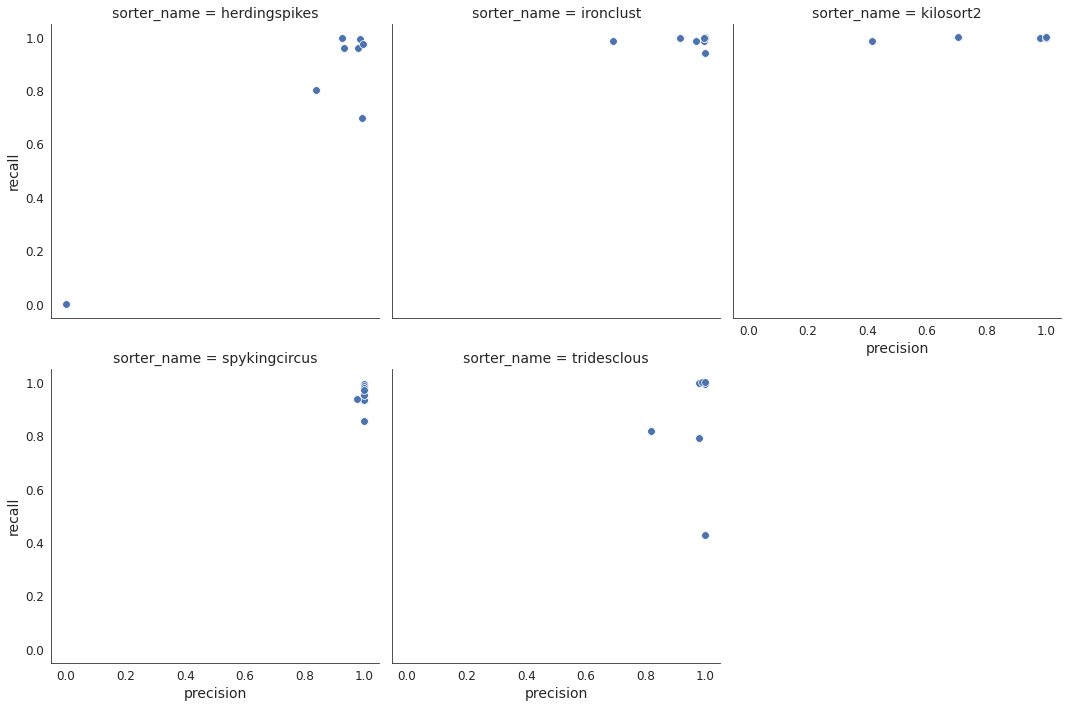

In [30]:
sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='precision', y='recall', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)

## Accuracy vns SNR

In [31]:
df = dataframes['perf_by_units']
df

rec_name    sorter_name  gt_unit_id  accuracy    recall precision  \
0   20160426_patch3  herdingspikes           0  0.694297  0.698403  0.991604   
1   20170725_patch1  herdingspikes           0  0.919708  0.994737  0.924205   
2   20170713_patch1  spykingcircus           0  0.933659  0.933659         1   
3   20160426_patch3      kilosort2           0  0.703873  0.999409  0.704167   
4   20160426_patch2    tridesclous           0  0.426621  0.426621         1   
5   20160415_patch2      ironclust           0  0.683278  0.987194  0.689388   
6   20170621_patch1      kilosort2           0  0.411829  0.985783  0.414289   
7   20170803_patch1      kilosort2           0  0.998299  0.998822  0.999476   
8   20170713_patch1    tridesclous           0  0.988047  0.995882    0.9921   
9   20170728_patch2      ironclust           0  0.999789         1  0.999789   
10  20170713_patch1      kilosort2           0  0.998627  0.998627         1   
11  20170621_patch1  herdingspikes           0  0.897158  0.960753  0.931289   
12  20160426_patch2  spykingcircus           0  0.993174  0.993174         1   
13  20170725_patch1      kilosort2           0         1         1         1   
14  20170621_patch1  spykingcircus           0  0.984591  0.985182  0.999391   
15  20160426_patch3      ironclust           0  0.956397  0.985807   0.96975   
16  20170725_patch1    tridesclous           0  0.994737  0.994737         1   
17  20160415_patch2  herdingspikes           0  0.694369  0.803643  0.836245   
18  20160426_patch2  herdingspikes           0         0         0         0   
19  20160426_patch3    tridesclous           0   0.77836  0.791248  0.979502   
20  20160415_patch2      kilosort2           0  0.973838  0.995731  0.977921   
21  20170621_patch1    tridesclous           0  0.975485  0.995995  0.979327   
22  20160415_patch2    tridesclous           0  0.692271  0.818156  0.818156   
23  20170725_patch1      ironclust           0  0.979058  0.984211  0.994681   
24  20160426_patch3  spykingcircus           0  0.977568  0.979302  0.998192   
25  20170803_patch1      ironclust           0  0.997775  0.998167  0.999607   
26  20170803_patch1    tridesclous           0  0.989504  0.999607  0.989889   
27  20160426_patch2      kilosort2           0  0.997725  0.997725         1   
28  20160426_patch2      ironclust           0  0.993197  0.996587  0.996587   
29  20170713_patch1      ironclust           0   0.94115  0.941437  0.999676   
30  20170803_patch1  herdingspikes           0  0.939895  0.960073  0.978128   
31  20170728_patch2  spykingcircus           0  0.852991  0.852991         1   
32  20170621_patch1      ironclust           0  0.914097  0.997197  0.916452   
33  20170728_patch2    tridesclous           0         1         1         1   
34  20170725_patch1  spykingcircus           0  0.952632  0.952632         1   
35  20170803_patch1  spykingcircus           0  0.970153  0.970153         1   
36  20160415_patch2  spykingcircus           0  0.916064  0.937962  0.975148   
37  20170728_patch2  herdingspikes           0  0.981085  0.994103  0.986828   
38  20170728_patch2      kilosort2           0  0.998736  0.998736         1   
39  20170713_patch1  herdingspikes           0  0.968295  0.973463  0.994547   

   false_discovery_rate    miss_rate  
0            0.00839631     0.301597  
1             0.0757946   0.00526316  
2                     0    0.0663413  
3              0.295833  0.000591366  
4                     0     0.573379  
5              0.310612    0.0128059  
6              0.585711    0.0142171  
7           0.000523972   0.00117816  
8            0.00790033   0.00411774  
9           0.000210571            0  
10                    0   0.00137258  
11            0.0687112    0.0392471  
12                    0   0.00682594  
13                    0            0  
14          0.000609385    0.0148178  
15            0.0302501    0.0141928  
16                    0   0.00526316  
17             0.163755     

/home/samuel/.virtualenvs/py37/lib/python3.7/site-packages/pandas-1.0.3-py3.7-linux-x86_64.egg/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


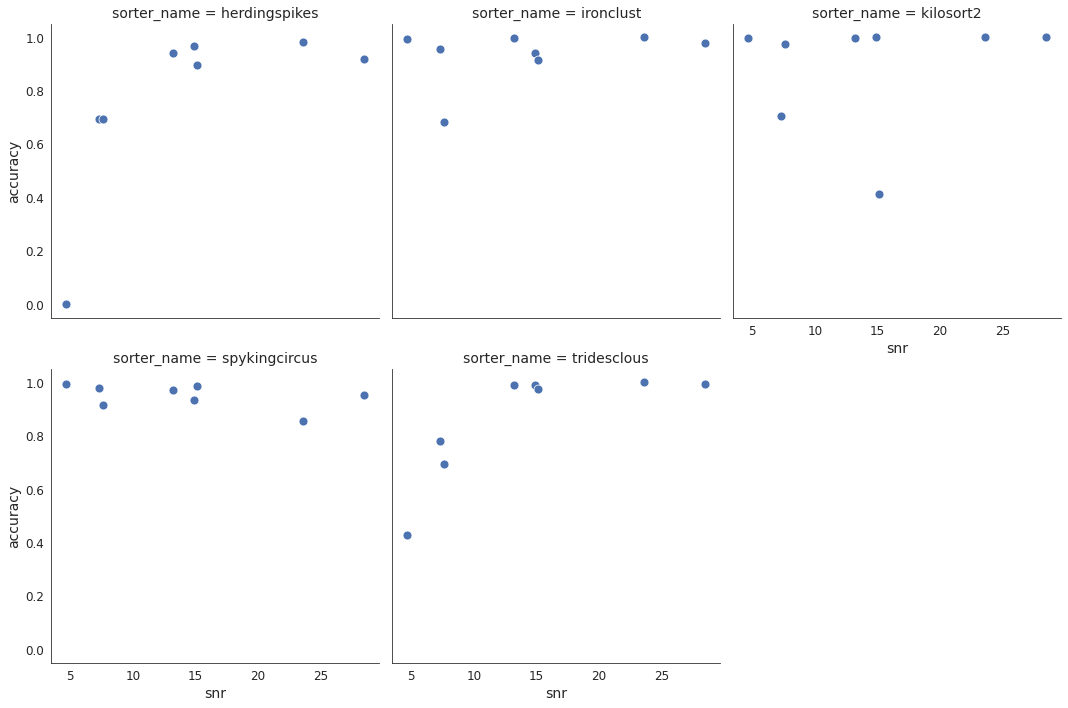

In [32]:
df = dataframes['perf_by_units']

# add snr to the by-unit table
df['snr'] = None
for rec_name, gt_id in snr.index:
    df['snr'].loc[(df['gt_unit_id']==gt_id) & (df['rec_name']==rec_name)] = snr.at[(rec_name, gt_id), 'snr']

sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=df, x='snr', y='accuracy', col='sorter_name',
        col_wrap=3, col_order=sorter_list, s=80)
